In [1]:
import pandas as pd
from glob import glob
from collections import defaultdict
from IPython.display import display
import faiss, json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchbiggraph.model import ComplexDiagonalDynamicOperator, DotComparator, CosComparator
import numpy as np
from functools import lru_cache
from tqdm import tqdm
import h5py, torch

### Setup

In [2]:
# Faiss flat inner-product index
# index = faiss.read_index('wikidata_complEx.idx')

# Faiss IVFFlat inner-product index
# index = faiss.read_index('wikidata_complEx_IVFFlat_IP_5.idx')
# index = faiss.read_index('wikidata_complEx_IVFFlat_IP_1024.idx')
# index = faiss.read_index('wikidata_complEx_IVFFlat_25000_IP.idx')
# index.nprobe = 1200

# Faiss HNSW Flat index
# index = faiss.read_index('wikidata_complEx_HNSWFlat_4_IP.idx')
# index = faiss.read_index('wikidata_complEx_HNSWFlat_64_IP.idx')

In [3]:
index = faiss.read_index('wikidata_complEx_IVF65536_HNSW32_IP.idx')
# Set the parameters
faiss.downcast_index(index.quantizer).hnsw.efSearch = 400
index.nprobe = 4

In [4]:
# metadata
with open('metadata-w-fuzzy.json') as fd:
    metadata = json.load(fd)

# entity to index mapping
with open('qnodes_id.json') as fd:
    complEx_entity_index = json.load(fd)
entity_count = len(complEx_entity_index)
complEx_index_entity = {v: k for k, v in complEx_entity_index.items()}

# relational to index mapping
rel_type_names = pd.read_csv('relation_types_tf.tsv', sep='\t', header=None)[0][:1285].to_list()
rel_index = {r: i for i, r in enumerate(rel_type_names)}
index_rel = {v: k for k, v in rel_index.items()}

In [5]:
# specify dimension
dim = 100

# operators
operator_lhs = ComplexDiagonalDynamicOperator(dim, 1285)
operator_rhs = ComplexDiagonalDynamicOperator(dim, 1285)
comparator = DotComparator()
cos_comparator = CosComparator()

# Load the operator's state dict
with h5py.File("model.v600.h5", "r") as hf:
    operator_state_dict_lhs = {
        "real": torch.from_numpy(hf["model/relations/0/operator/lhs/real"][...]),
        "imag": torch.from_numpy(hf["model/relations/0/operator/lhs/imag"][...]),
    }
    operator_state_dict_rhs = {
        "real": torch.from_numpy(hf["model/relations/0/operator/rhs/real"][...]),
        "imag": torch.from_numpy(hf["model/relations/0/operator/rhs/imag"][...]),
    }

operator_lhs.load_state_dict(operator_state_dict_lhs)
operator_rhs.load_state_dict(operator_state_dict_rhs)

# Load the embeddings
with h5py.File("embeddings_all_0.v600.h5", "r") as hf:
    embedding = torch.from_numpy(hf["embeddings"][...])

### Utility functions

In [6]:
@lru_cache(maxsize = 50000)
def get_embed(head, relation=None):
    ''' This function generate the embeddings for the tail entities:
            Head entities: Obtained from the model
            Head + relation: Obtained using torch
    '''
    if relation is None:
        return embedding[complEx_entity_index[head], :].detach().numpy()
    return  operator_lhs(
                embedding[complEx_entity_index[head], :].view(1, dim),
                torch.tensor([rel_index[relation]])
            ).detach().numpy()[0]

In [7]:
@lru_cache(maxsize = 10000)
def get_embed_rev(tail, relation=None):
    ''' This function generate the embeddings for the head entities:
            Tail entities: Obtained from the model
            Tail - relation: Obtained using torch
    '''
    if relation is None:
        return embedding[complEx_entity_index[tail], :].detach().numpy()
    return  operator_rhs(
                embedding[complEx_entity_index[tail], :].view(1, dim),
                torch.tensor([rel_index[relation]])
            ).detach().numpy()[0]

In [8]:
@lru_cache(maxsize=10000)
def neighbors_torch(qnode, relation):
    ''' This function returns the nearest neighbors,
        given the head and the relation (Using the torch command)
    '''
    # Load the offsets of the entities and the index of the relation type
    src_entity_offset = complEx_entity_index[qnode]
    rel_type_index = rel_type_names.index(relation)

    src_embedding = embedding[src_entity_offset, :]
    dest_embeddings = embedding

    # Calculate the scores
    scores, _, _ = comparator(
        comparator.prepare(src_embedding.view(1, 1, dim)).expand(1, entity_count, dim),
        comparator.prepare(
            operator_rhs(
                dest_embeddings,
                torch.tensor([rel_type_index]).expand(entity_count),
            ).view(1, entity_count, dim),
        ),
        torch.empty(1, 0, dim),  # Left-hand side negatives, not needed
        torch.empty(1, 0, dim),  # Right-hand side negatives, not needed
    )
    
    return scores.flatten()

In [9]:
@lru_cache(maxsize=10000)
def neighbors_faiss(head, relation, tail=None, k=10):
    ''' This function returns the nearest neighbors
        given the head and the relation (Using the Faiss index)
    '''
    if not tail:
        return index.search(get_embed(head, relation).reshape(1,-1), k)
    else:
        return index.search(get_embed_rev(tail, relation).reshape(1,-1), k)

In [10]:
def neighbors(head, relation, tail=None, k=10):
    ''' This function returns the nearest neighbors
        given the head and the relation (Using the Faiss index)
    '''
    if not tail:
        return index.search(get_embed(head, relation).reshape(1,-1), k)
    else:
        return index.search(get_embed_rev(tail, relation).reshape(1,-1), k)

In [11]:
def get_neighbors(head, relation, tail=None, k=10):
    scores, ranking = neighbors_faiss(head, relation, tail)
    top_entities = [complEx_index_entity[index] for index in ranking[0] if index>0]
    top_scores = scores[0][:len(top_entities)]
    return top_scores, top_entities

In [12]:
def get_neighbors_(head, relation, tail=None, k=10):
    scores, ranking = neighbors(head, relation, tail)
    top_entities = [complEx_index_entity[index] for index in ranking[0] if index>0]
    top_scores = scores[0][:len(top_entities)]
    return top_scores, top_entities

In [13]:
def has_candidate(head, relation, tail=None, cutoff=10, k=5, verbose=False):
    ''' Given a qnode and a relation, 
        check if the candidate has a valid tail entity that is above the cut off points
    '''

    top_scores, top_entities = get_neighbors(head, relation, tail, k)
        
    for e, s in zip(top_entities, top_scores):
        # print(e)
        if e == head or e == tail:
            continue
        if s >= cutoff:
            if verbose:
                print(e, s)
            return e
        
    return None

In [14]:
def get_centroid(qnodes):
    ''' Calculate the centroid of a given list of qnodes '''
    embeddings = [get_embed(qnode) for qnode in qnodes]
    return np.mean(embeddings, axis=0)

In [56]:
index.nprobe = 4

In [57]:
%time get_neighbors_('Q30', 'P31')

CPU times: user 572 ms, sys: 21 ms, total: 593 ms
Wall time: 16.2 ms


(array([22.720057, 21.73102 , 18.87265 , 18.492632, 13.012012, 12.51023 ,
        11.849326, 11.721074,  9.497982,  9.257093], dtype=float32),
 ['Q3624078',
  'Q6256',
  'Q7270',
  'Q41614',
  'Q20181813',
  'Q4209223',
  'Q43702',
  'Q859563',
  'Q1520223',
  'Q11514315'])

### Graph extract

In [16]:
# Macros
SINGLETON_CORRECT = 'singleton (correct)'
SINGLETON_INCORRECT = 'singleton (incorrect)'
NON_SINGLETON_CORRECT = 'nonsingleton (correct)'
NON_SINGLETON_INCORRECT = 'nonsingleton (incorrect)'
FUZZY_CORRECT = 'correct'
FUZZY_INCORRECT = 'incorrect'
AMBIGUOUS = 'ambiguous'

In [17]:
ANNOTATE = False

In [18]:
def assign_group(qnode, datasetid, target='exact'):
    ''' Assign the groups of entities based on evaluation '''
    if target == 'exact':
        if qnode in metadata[datasetid]['exact']['singleton-correct']:
            return SINGLETON_CORRECT
        if qnode in metadata[datasetid]['exact']['singleton-incorrect']:
            return SINGLETON_INCORRECT
        if qnode in metadata[datasetid]['exact']['non-singleton-correct']: 
            return NON_SINGLETON_CORRECT
        return NON_SINGLETON_INCORRECT
    else:
        if qnode in metadata[datasetid]['fuzzy']['correct']:
            return FUZZY_CORRECT
        if qnode in metadata[datasetid]['fuzzy']['incorrect']:
            return FUZZY_INCORRECT

In [19]:
def build_candidates(datasetid, target='exact', singleton=False, correct=False):
    ''' Build the candidate array from the dataset '''
    if target == 'exact':
        if not singleton and not correct:
            array = metadata[datasetid]['exact']['singleton-correct'] + \
                    metadata[datasetid]['exact']['singleton-incorrect'] + \
                    metadata[datasetid]['exact']['non-singleton-correct'] + \
                    metadata[datasetid]['exact']['non-singleton-incorrect']
        elif singleton and not correct:
            array = metadata[datasetid]['exact']['singleton-correct'] + \
                    metadata[datasetid]['exact']['singleton-incorrect']
        else:
            array = metadata[datasetid]['exact']['singleton-correct'] 
    else:
        array = metadata[datasetid]['fuzzy']['correct'] + \
                metadata[datasetid]['fuzzy']['incorrect']
    return array

In [20]:
def drop_candidates(candidates):
    ''' Drop the entities that do not have graph embeddings '''
    # Drop qnodes that are not in the index
    olen = len(candidates)
    candidates = [qnode for qnode in candidates if qnode in complEx_entity_index]
    print(f'{olen-len(candidates)} entities dropped.')
    return candidates

In [21]:
def graph_entities(candidates, labels, embeddings,
                   target='exact', perplexity=5, metric='euclidean'):
    ''' Graph the candidates that have an embedding '''
    
    # Prepare the TSNE graph for the candidates
    reduced_embeddings = TSNE(perplexity=perplexity, metric=metric, n_iter=5000).fit_transform(embeddings)

    df = pd.DataFrame(dict(x=[x[0] for x in reduced_embeddings], 
                           y=[x[1] for x in reduced_embeddings], 
                           label=labels))
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(12,9))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax.title.set_text(f'TSNE of Graph Embeddings, perplexity={perplexity}')
    for name, group in groups:
        if name == SINGLETON_CORRECT or name == FUZZY_CORRECT:
            ax.plot(group.x, group.y, marker='o', linestyle='', color='g', ms=8, label=name)
        elif name == NON_SINGLETON_CORRECT:
            ax.plot(group.x, group.y, marker='o', linestyle='', color='b', ms=8, label=name)
        elif name == SINGLETON_INCORRECT:
            ax.plot(group.x, group.y, marker='X', linestyle='', color='r', ms=8, label=name)
        elif name == AMBIGUOUS:
            ax.plot(group.x, group.y, marker='P', color='m', linestyle='', ms=6, label=name)
        elif 'reverse' in name:
            if SINGLETON_CORRECT in name:
                ax.plot(group.x, group.y, marker='*', linestyle='', color='g', ms=8, label=name)
            elif NON_SINGLETON_CORRECT in name:
                ax.plot(group.x, group.y, marker='*', linestyle='', color='b', ms=8, label=name)
            elif SINGLETON_INCORRECT in name:
                ax.plot(group.x, group.y, marker='_', linestyle='', color='r', ms=8, label=name)                
            else:
                ax.plot(group.x, group.y, marker='_', linestyle='', ms=6, label=name)
        else:
            ax.plot(group.x, group.y, marker='x', color='y', linestyle='', ms=6, label=name)
    ax.legend(bbox_to_anchor=(1,0.25), loc='upper left')

    if ANNOTATE:
        for qnode, loc in zip(candidates, reduced_embeddings):
            ax.annotate(qnode, loc)
    
    if ANNOTATE_SIN_IN:
        for qnode, l, loc in zip(candidates, labels, reduced_embeddings):
            if l == SINGLETON_INCORRECT:
                ax.annotate(qnode, loc)
        

    plt.show()

In [22]:
def extract_from_df(df, mode='exact'):

    ''' Generate the data we need '''
    # Inputs to graph_entities()
    candidates = []
    labels = []
    embeddings = []
    
    # extract data from frame
    if mode == 'exact':
        df = df[df['method'] == 'exact-match']
    else:
        df = df[df['method'] != 'exact-match']
    
    # count occurences
    label_counts = defaultdict(int)
    for label in df['label']:
        label_counts[label] += 1
    
    drops = 0
    # Parse data from dataframe
    for i, row in df.iterrows():
        
        if row['kg_id'] not in complEx_entity_index:
            drops += 1
            continue
        
        label = row['label']
        candidates.append(row['kg_id'])
        embeddings.append(get_embed(row['kg_id']))
        
        # Assign label
        if mode == 'exact':
            if label_counts[label] == 1:
                labels.append(SINGLETON_CORRECT if row['evaluation_label'] == 1 else SINGLETON_INCORRECT)    
            else:
                labels.append(NON_SINGLETON_CORRECT if row['evaluation_label'] == 1 else NON_SINGLETON_INCORRECT)
        else:
            labels.append(FUZZY_CORRECT if row['evaluation_label'] == 1 else FUZZY_INCORRECT)
            
    # print(f'{drops} entities dropped')
    
    return candidates, labels, embeddings

In [23]:
def graph_entities_from_df(df, relation=None, truncate=None, mode='exact', 
                           perplexity=5, metric='euclidean', skip=False):
    
    candidates, labels, embeddings = extract_from_df(df, mode=mode)
    
    if not skip:
        graph_entities(candidates, labels, embeddings, perplexity=perplexity, metric=metric)
    
    if relation:
        if not truncate:
            embeddings = list(map(lambda x: get_embed(x, relation), candidates))
        else:
            candidates_, labels_ = [], []
            for c, l in zip(candidates, labels):
                if has_candidate(c, relation, cutoff=truncate):
                    candidates_.append(c)
                    labels_.append(l)
            print(f'{len(candidates)-len(candidates_)} entities truncated')
            candidates, labels = candidates_, labels_
            embeddings = list(map(lambda x: get_embed(x, relation), candidates))
        
        if len(candidates) > 1:
            graph_entities(candidates, labels, embeddings, perplexity=perplexity, metric=metric)
    
    '''
    for c, l in zip(candidates, labels):
        if l == SINGLETON_INCORRECT:
            print(c)
    '''

In [24]:
def calculate_truncate_percent(df, relation=None, truncate=None, mode='exact', aggregate=False):

    candidates, labels, embeddings = extract_from_df(df, mode=mode)
    
    truncates = defaultdict(int)
    totals = defaultdict(int)
    for c, l in zip(candidates, labels):
        if not has_candidate(c, relation, cutoff=truncate):
            truncates[l] += 1
        totals[l] += 1
    
    if mode == 'exact':
        if not aggregate:
            return [truncates[SINGLETON_CORRECT] / totals[SINGLETON_CORRECT],
                    truncates[SINGLETON_INCORRECT] / totals[SINGLETON_INCORRECT],
                    truncates[NON_SINGLETON_CORRECT] / totals[NON_SINGLETON_CORRECT],
                    truncates[NON_SINGLETON_INCORRECT] / totals[NON_SINGLETON_INCORRECT]
                   ]
        else:
            return [ (truncates[SINGLETON_CORRECT] + truncates[NON_SINGLETON_CORRECT]) /  \
                     (totals[SINGLETON_CORRECT] + totals[NON_SINGLETON_CORRECT]),
                     (truncates[SINGLETON_INCORRECT] + truncates[NON_SINGLETON_INCORRECT]) / \
                     (totals[SINGLETON_INCORRECT] + totals[NON_SINGLETON_INCORRECT])
                   ]
    else:
        return [truncates[FUZZY_CORRECT] / totals[FUZZY_CORRECT],
               truncates[FUZZY_INCORRECT] / totals[FUZZY_INCORRECT]
               ]

In [25]:
ANNOTATE = False
ANNOTATE_SIN_IN = True

In [26]:
W_SINGLETON_CORRECT = 1
W_SINGLETON_INCORRECT = 1
W_NON_SINGLETON_CORRECT = 1
W_NON_SINGLETON_INCORRECT = 1

W_CORRECT = 1
W_INCORRECT = 1

In [27]:
def calculate_truncate_loss(df, relation=None, truncate=None, mode='exact', aggregate=False):
    
    results = calculate_truncate_percent(df, relation, truncate, mode=mode, aggregate=aggregate)
    
    if mode == 'exact':
        if not aggregate:
            results[0] *= W_SINGLETON_CORRECT
            results[1] = (1 - results[1]) * W_SINGLETON_INCORRECT
            results[2] *= W_NON_SINGLETON_CORRECT
            results[3] = (1 - results[3]) * W_NON_SINGLETON_INCORRECT
            return np.mean(results)
        else:
            results[0] *= W_CORRECT
            results[1] = (1 - results[1]) * W_INCORRECT
            return np.mean(results)            
    else:
        results[0] *= W_CORRECT
        results[1] = (1 - results[1]) * W_INCORRECT
        return np.mean(results)

In [28]:
def get_top_tails(datasetid, candidates, relation, target='exact'):
    ''' Given a list of candidates, check their top candidate '''
    
    projections = defaultdict(set)
    counts = defaultdict(set)
    for cand in candidates:
        
        for ent in get_neighbors(cand, relation)[1]:
            
            # skip itself
            if ent == cand:
                continue
            
            # Keep the grouping info
            group_id = assign_group(cand, datasetid, target)
            projections[group_id].add(ent)
            if group_id in [SINGLETON_CORRECT, NON_SINGLETON_CORRECT, FUZZY_CORRECT]:
                counts[ent].add('correct')
            else:
                counts[ent].add('incorrect')
            
            # Add the highest ranking only
            break
    
    # Convert group info to counts
    for ent in counts:
        counts[ent] = len(counts[ent])
    
    # Count ambiguous entities (mapped by both incorrect and correct ones)
    ambiguities = set()
    for ent in counts:
        if counts[ent] > 1:
            ambiguities.add(ent)
            
    for k in projections:
        # remove ambiguities
        for ent in ambiguities:
            projections[k].discard(ent)
    
    # append ambigous entities
    projections['ambiguous'] = ambiguities
    
    # Convert to list
    output_qnodes = []
    output_labels = []
    for label in projections:
        for qnode in projections[label]:
            output_qnodes.append(qnode)
            output_labels.append(label)
            
    return output_qnodes, output_labels

In [29]:
def graph_embeddings(datasetid, relation=None, target='exact', perplexity=5, 
                metric='euclidean', skip=False, truncate=None):
    
    # Get candidates from dataset, also drop those who do not have embeddings
    candidates = build_candidates(datasetid, target=target)
    candidates = drop_candidates(candidates)    
    labels = [assign_group(qnode, datasetid, target) for qnode in candidates]

    # Graph 1: The embeddings of the original graph
    if not skip:
        embeddings = [get_embed(qnode) for qnode in candidates]
        graph_entities(candidates, labels, embeddings, perplexity=perplexity)
    
    if relation:

        if truncate:
            # Summary statistics
            prev_len = len(candidates)
            if target == 'exact':
                sin_c = len([x for x in labels if x == SINGLETON_CORRECT])
                sin_ic = len([x for x in labels if x == SINGLETON_INCORRECT])
                nonsin_c = len([x for x in labels if x == NON_SINGLETON_CORRECT])
                nonsin_ic = len([x for x in labels if x == NON_SINGLETON_INCORRECT])
            else:
                c = len([x for x in labels if x == FUZZY_CORRECT])
                ic = len([x for x in labels if x == FUZZY_INCORRECT])
            
            candidates = [qnode for qnode in candidates if has_candidate(qnode, relation, cutoff=truncate)]
            labels = [assign_group(qnode, datasetid, target) for qnode in candidates]
            # Summary
            print(f'{len(candidates)-prev_len} cases truncated')
            if target == 'exact':
                sin_c_t = len([x for x in labels if x == SINGLETON_CORRECT])
                print(f'singleton (correct): {sin_c - sin_c_t} output of {sin_c}, percent: {(sin_c - sin_c_t) / sin_c}')
                sin_ic_t = len([x for x in labels if x == SINGLETON_INCORRECT])
                print(f'singleton (incorrect): {sin_ic - sin_ic_t} output of {sin_ic}, percent: {(sin_ic - sin_ic_t) / sin_ic}')
                nonsin_c_t = len([x for x in labels if x == NON_SINGLETON_CORRECT])
                print(f'nonsingleton (correct): {nonsin_c - nonsin_c_t} output of {nonsin_c}, percent: {(nonsin_c - nonsin_c_t) / nonsin_c}')
                nonsin_ic_t = len([x for x in labels if x == NON_SINGLETON_INCORRECT])
                print(f'nonsingleton (correct): {nonsin_ic - nonsin_ic_t} output of {nonsin_ic}, percent: {(nonsin_ic - nonsin_ic_t) / nonsin_ic}')
            else:
                c = len([x for x in labels if x == FUZZY_CORRECT])
                ic = len([x for x in labels if x == FUZZY_INCORRECT])
            
            projected_embeddings = [get_embed_rev(qnode, relation) for qnode in candidates]
            # Graph2b: Projected Embeddings with truncation
            graph_entities(candidates, labels, projected_embeddings, perplexity=perplexity)    
        else:
            # Graph2a: Projected Embeddings
            projected_embeddings = [get_embed_rev(qnode, relation) for qnode in candidates]
            graph_entities(candidates, labels, projected_embeddings, perplexity=perplexity)            
             
        # Graph 3: The distinct projections of the candidates
        mapped_nodes, mapped_labels = get_top_tails(datasetid, candidates, relation, target=target)
        mapped_embeddings = [get_embed(qnode) for qnode in mapped_nodes]
        graph_entities(mapped_nodes, mapped_labels, mapped_embeddings, perplexity=perplexity)
        
        distance_singleton_all = None
        distance_singleton_correct = None
        # Calculate the centroid of singletons, non-singletons
        if target == 'exact':
            centroid_singleton = get_centroid(build_candidates(datasetid, target=target, singleton=True))
            centroid_singleton_correct = get_centroid(build_candidates(datasetid, target=target, singleton=True, correct=True))
        
            distance_singleton_all = defaultdict(list)
            distance_singleton_correct = defaultdict(list)
            for qnode, label in zip(mapped_nodes, mapped_labels):
                neighbors = get_neighbors(None, relation, qnode)[1]
                distance_singleton_all[label].append(np.linalg.norm(get_centroid(neighbors) - centroid_singleton))
                distance_singleton_correct[label].append(np.linalg.norm(get_centroid(neighbors) - centroid_singleton_correct))
            
            # Average the distance to centroids
            for k in distance_singleton_all:
                distance_singleton_all[k] = np.mean(distance_singleton_all[k])
                distance_singleton_correct[k] = np.mean(distance_singleton_correct[k])
                    
        # Graph 4: Calculate the reversedly-projected embeddings, along with the embeddings in the original space
        rev_embeddings = [get_embed_rev(qnode, relation) for qnode in mapped_nodes]
        for i in range(len(mapped_labels)):
            mapped_labels[i] += ' - reverse'
        embeddings = [get_embed(qnode) for qnode in candidates]
        graph_entities(candidates + mapped_nodes, labels + mapped_labels, embeddings + rev_embeddings, 
                       perplexity=perplexity)
                
        return distance_singleton_all, distance_singleton_correct

In [30]:
def plot_from_file(fname, mode='exact', relation=None, truncate=None):
    
    df = pd.read_csv(fname)
    
    if mode == 'exact':
        df = df[df['method'] == 'exact-match']
    else:
        df = df[df['method'] != 'exact-match']
    
    # Get not null
    df = df[df['kg_id'].notnull()]
    
    graph_entities_from_df(df, relation=relation, truncate=truncate)

In [31]:
metadata.keys()

dict_keys(['14067031', '14380604', '28086084', '29414811', '39759273', '45073662', '50270082', '52299421', '84575189'])

### Pope dataset

In [32]:
key = '28086084'
metric_ = 'cosine'
property_ = 'P106'
group = 'exact'
skip = False
truncate = 10

30 entities dropped.


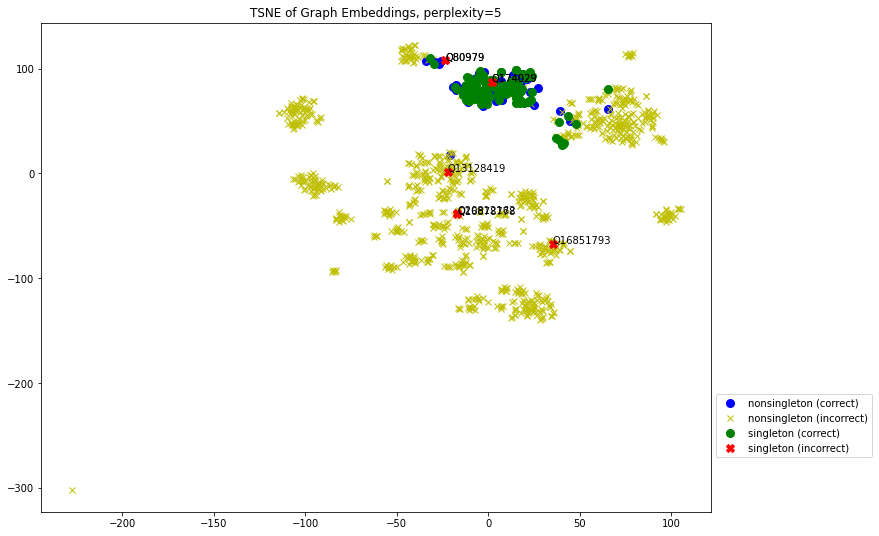

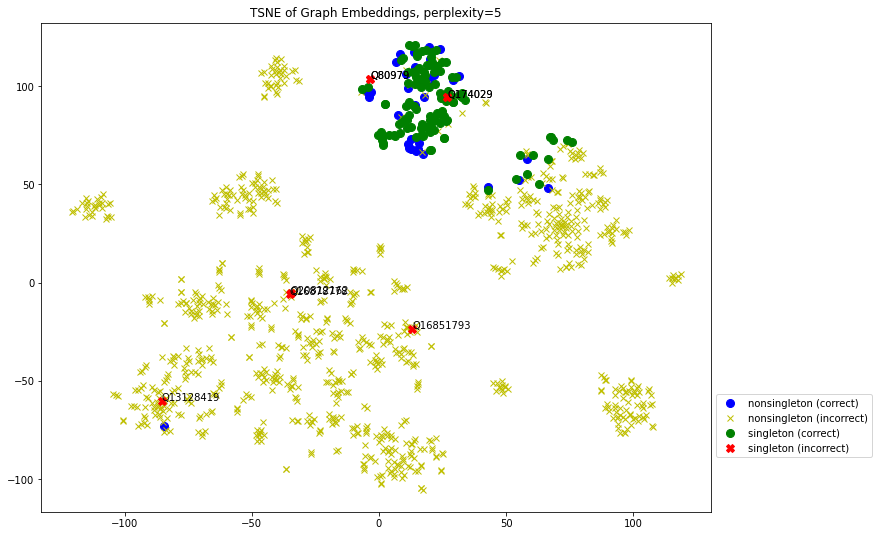

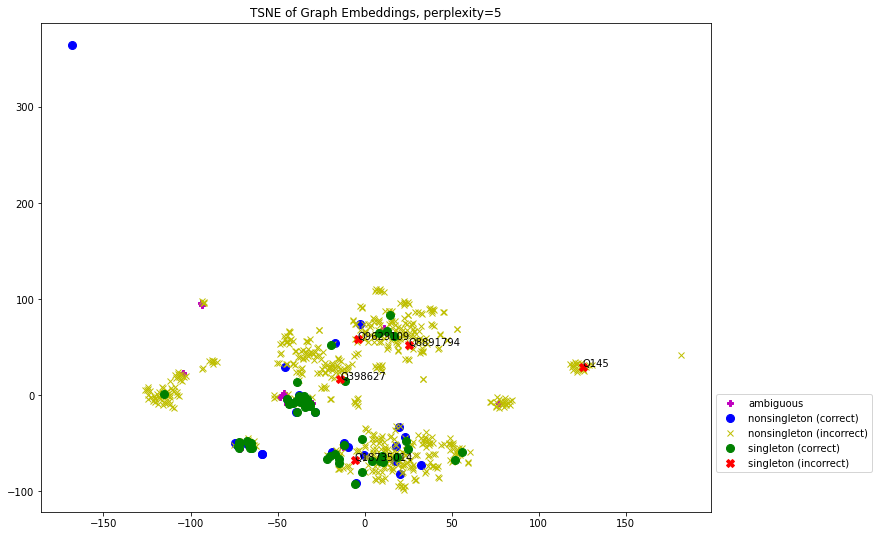

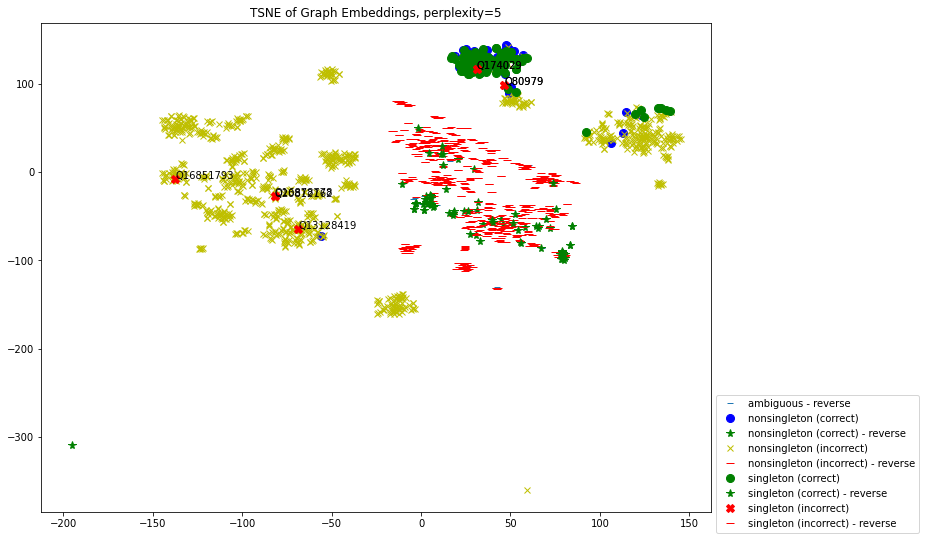

(defaultdict(list,
             {'singleton (correct)': 2.3334396,
              'singleton (incorrect)': 3.203429,
              'nonsingleton (correct)': 2.4774377,
              'nonsingleton (incorrect)': 2.9717064,
              'ambiguous': 2.0933964}),
 defaultdict(list,
             {'singleton (correct)': 2.3831317,
              'singleton (incorrect)': 3.2747989,
              'nonsingleton (correct)': 2.5300229,
              'nonsingleton (incorrect)': 3.0361848,
              'ambiguous': 2.1387913}))

In [33]:
graph_embeddings(key, property_, group, perplexity=5, metric=metric_, \
                 skip=skip, truncate=None)

In [ ]:
graph_embeddings(key, property_, group, perplexity=5, metric=metric_, \
                 skip=skip, truncate=truncate)

### Graph directly from data

### Pope

In [291]:
df = pd.read_csv('../pope.csv')

In [292]:
# Get exact match
df = df[df['method'] == 'exact-match']
# Get not null
df = df[df['kg_id'].notnull()]

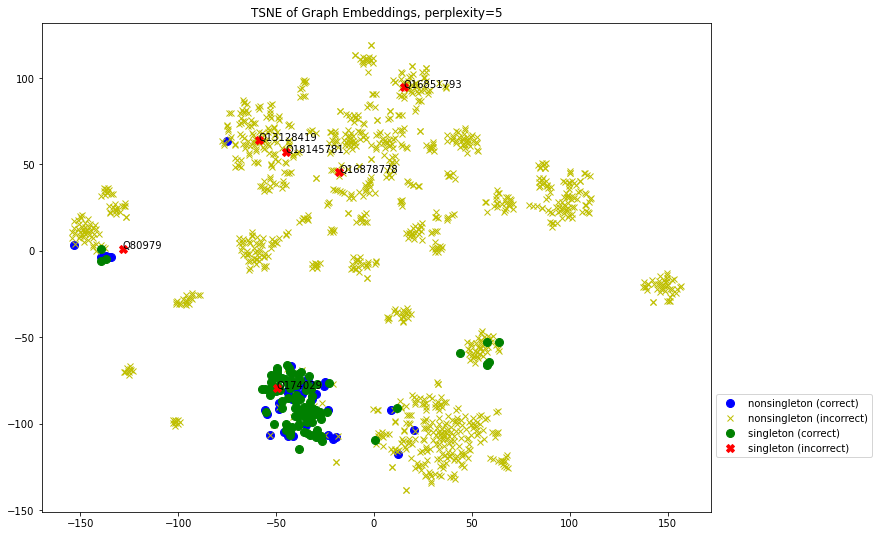

1104 entities truncated


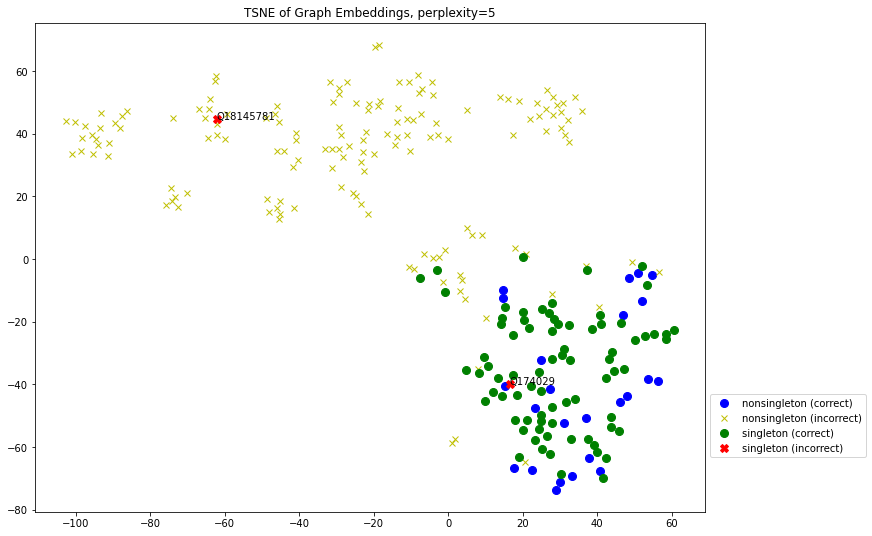

In [293]:
graph_entities_from_df(df, 'P106', truncate=1)

### Games

In [206]:
games = pd.read_csv('../game.csv')
# Get exact match
# games = games[games['method'] == 'exact-match']
# Get not null
games = games[games['kg_id'].notnull()]

In [311]:
truncate_loss = dict()
for key in tqdm(rel_index):
    truncate_loss[key] = calculate_truncate_loss(games, key, 0.005)
list(sorted(truncate_loss.items(), key=lambda x: x[1]))[:10]

100%|██████████| 1285/1285 [01:41<00:00, 12.71it/s]


[('P739', 0.08333333333333334),
 ('P1558', 0.09090909090909091),
 ('P4312', 0.13787878787878788),
 ('P840', 0.1431818181818182),
 ('P3440', 0.14393939393939392),
 ('P408', 0.15151515151515152),
 ('P118', 0.15303030303030304),
 ('P2936', 0.1553030303030303),
 ('P1792', 0.15606060606060607),
 ('P6902', 0.1590909090909091)]

In [314]:
truncate_loss_agg = dict()
for key in tqdm(rel_index):
    truncate_loss_agg[key] = calculate_truncate_loss(games, key, 0.5, aggregate=True)
list(sorted(truncate_loss_agg.items(), key=lambda x: x[1]))[:10]

100%|██████████| 1285/1285 [01:40<00:00, 12.73it/s]


[('P739', 0.14705882352941174),
 ('P1558', 0.1855203619909502),
 ('P4312', 0.22737556561085975),
 ('P1264', 0.22963800904977374),
 ('P5804', 0.23303167420814483),
 ('P3440', 0.23529411764705882),
 ('P1456', 0.24208144796380093),
 ('P4195', 0.24208144796380093),
 ('P840', 0.24773755656108595),
 ('P4608', 0.251131221719457)]

In [290]:
truncate_loss_fuzzy = dict()
for key in tqdm(rel_index):
    truncate_loss_fuzzy[key] = calculate_truncate_loss(games, key, 0.5, mode='fuzzy')
list(sorted(truncate_loss_fuzzy.items(), key=lambda x: x[1]))[:10]

100%|██████████| 1285/1285 [1:07:59<00:00,  3.17s/it]


[('P400', 0.21280360860513534),
 ('P2936', 0.24314133703446683),
 ('P3448', 0.2452000925283368),
 ('P840', 0.25477677538746246),
 ('P1877', 0.2573328706916493),
 ('P5804', 0.2599467962063382),
 ('P3440', 0.26114966458477906),
 ('P6902', 0.2636941938468656),
 ('P170', 0.26800832755031223),
 ('P1558', 0.27004395095998146)]

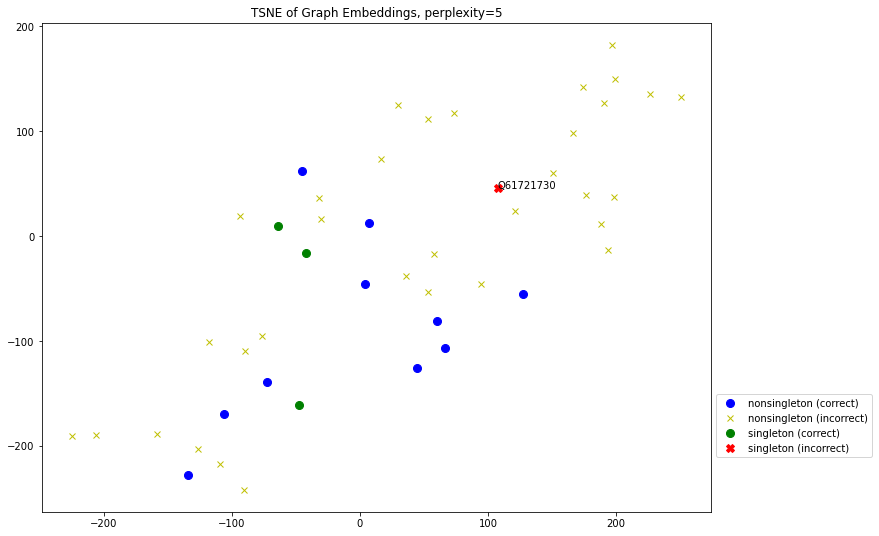

32 entities truncated


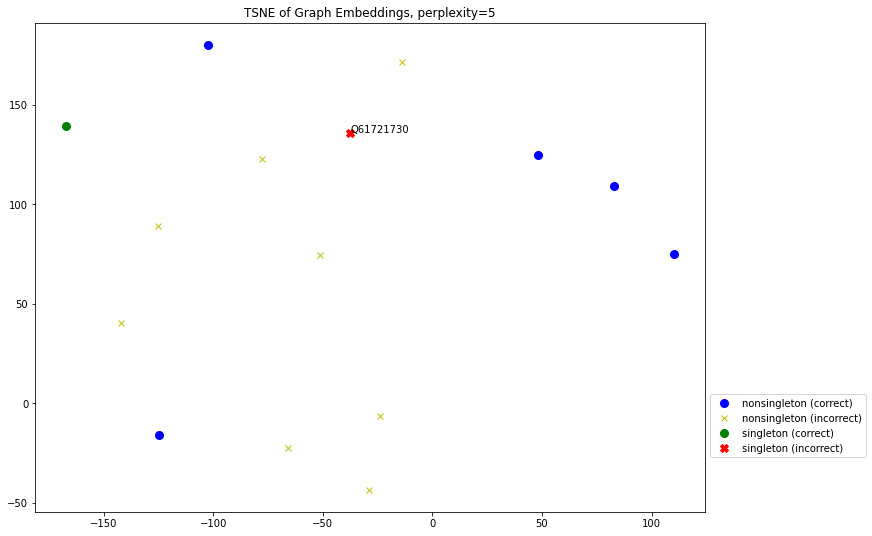

In [320]:
graph_entities_from_df(games, 'P31', truncate=0.005)

### Magazine

In [220]:
magazine = pd.read_csv('../magazine.csv')
# Get exact match
# magazine = magazine[magazine['method'] == 'exact-match']
# Get not null
magazine = magazine[magazine['kg_id'].notnull()]

In [221]:
magazine_exact = magazine[magazine['method'] == 'exact-match']
magazine_exact = magazine_exact[magazine_exact['evaluation_label'] == 1]

In [222]:
magazine_exact

,column,row,label,context,label_clean,kg_id,kg_labels,kg_aliases,method,kg_descriptions,...,GT_kg_label,evaluation_label,smallest_qnode_number,monge_elkan,des_cont_jaccard,vote_smallest_qnode_number,vote_monge_elkan,vote_des_cont_jaccard,votes,graph-embedding-score
183,2,0,Science,1|1780,Science,Q192864,Science,"Sci. (N. Y., N. Y.)|sciencemag.org/|Science Ma...",exact-match,academic journal of the American Association f...,...,Science,1,0,1.000000,0.0,0,1,0,1,0.496886
381,2,1,Nature,2|1732,Nature,Q180445,Nature,Nature Magazine|Nature (Lond.)|magazine Nature,exact-match,scientific journal,...,Nature,1,0,1.000000,0.0,0,1,0,1,0.394424
507,2,2,Proceedings of the National Academy of Science...,3|1080,Proceedings of the National Academy of Science...,Q1146531,Proceedings of the National Academy of Science...,The Proceedings of the National Academy of Sci...,exact-match,scientific journal,...,Proceedings of the National Academy of Science...,1,0,1.000000,0.0,0,1,0,1,0.413615
710,2,4,New England Journal of Medicine,5|948,New England Journal of Medicine,Q582728,The New England Journal of Medicine,New England Journal of Medicine|N. Engl. J. Me...,exact-match,peer-reviewed medical journal,...,The New England Journal of Medicine,1,0,0.962963,0.0,0,1,0,1,0.425170
811,2,5,The Astrophysical Journal,6|794,The Astrophysical Journal,Q598789,The Astrophysical Journal,Astrophys. J.|Astrophysical Journal,exact-match,scientific journal (0004-637X),...,The Astrophysical Journal,1,0,1.000000,0.0,0,1,0,1,0.443974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10293,2,89,Journal of Paleontology,90|81,Journal of Paleontology,Q217924,Journal of Paleontology,NaN,exact-match,scientific journal,...,Journal of Paleontology,1,0,1.000000,0.0,0,1,0,1,0.342156
10496,2,91,Annals of Neurology,92|79,Annals of Neurology,Q564414,Annals of Neurology,NaN,exact-match,journal,...,Annals of Neurology,1,0,1.000000,0.0,0,1,0,1,0.467611
10699,2,93,New Scientist,94|78,New Scientist,Q525592,New Scientist,NaN,exact-match,scientific journal,...,New Scientist,1,0,1.000000,0.0,0,1,0,1,0.395115
10901,2,95,Journal of the National Cancer Institute,96|77,Journal of the National Cancer Institute,Q400279,Journal of the National Cancer Institute,JNCI|National Cancer Institute. Journal|J Natl...,exact-match,peer-reviewed scientific journal,...,Journal of the National Cancer Institute,1,0,1.000000,0.0,0,1,0,1,0.410220


In [288]:
truncate_loss_magazine = dict()
for key in tqdm(rel_index):
    truncate_loss_magazine[key] = calculate_truncate_loss(magazine, key, 0.05)
list(sorted(truncate_loss_magazine.items(), key=lambda x: x[1]))[:10]

100%|██████████| 1285/1285 [10:48<00:00,  1.98it/s]


[('P870', 0.07113320707070707),
 ('P921', 0.08778409090909091),
 ('P2700', 0.11623376623376624),
 ('P546', 0.1183328823953824),
 ('P8329', 0.148829816017316),
 ('P3448', 0.15789141414141414),
 ('P1028', 0.15925099206349205),
 ('P6606', 0.1658662518037518),
 ('P3712', 0.16839375901875903),
 ('P1312', 0.1725333694083694)]

In [289]:
truncate_loss_magazine_agg = dict()
for key in tqdm(rel_index):
    truncate_loss_magazine_agg[key] = calculate_truncate_loss(magazine, key, 0.05, aggregate=True)
list(sorted(truncate_loss_magazine_agg.items(), key=lambda x: x[1]))[:10]

100%|██████████| 1285/1285 [10:44<00:00,  1.99it/s]


[('P870', 0.1113390863556816),
 ('P921', 0.15415484883229738),
 ('P31', 0.16003862168849192),
 ('P123', 0.17325448071932892),
 ('P291', 0.17346569307826926),
 ('P407', 0.17494417959085148),
 ('P2770', 0.18647033975016597),
 ('P98', 0.1913583971999276),
 ('P546', 0.19600506909661455),
 ('P50', 0.1962464546496892)]

In [ ]:
truncate_loss_magazine_fuzzy = dict()
for key in tqdm(rel_index):
    truncate_loss_magazine_fuzzy[key] = calculate_truncate_loss(magazine, key, 0.05, mode='fuzzy')
list(sorted(truncate_loss_magazine_fuzzy.items(), key=lambda x: x[1]))[:10]

In [295]:
calculate_truncate_loss(magazine, 'P101', 0.5)

0.3317054473304474

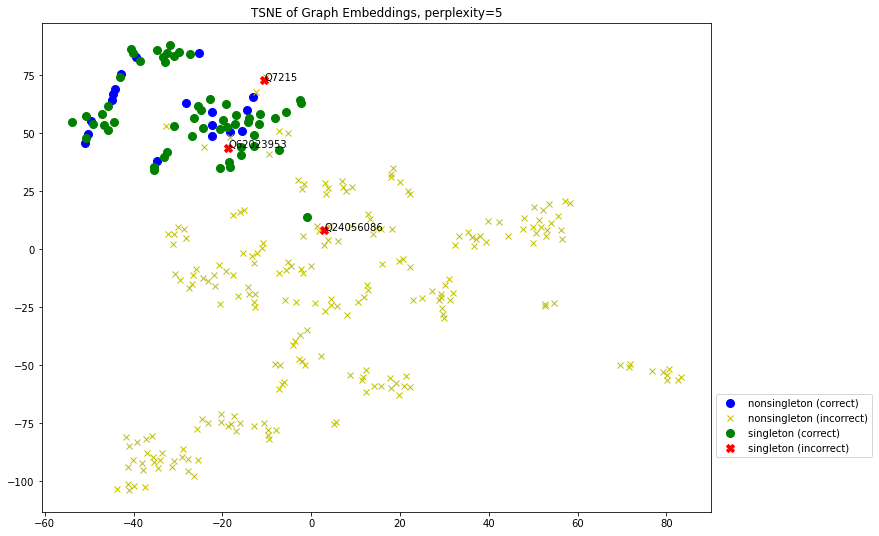

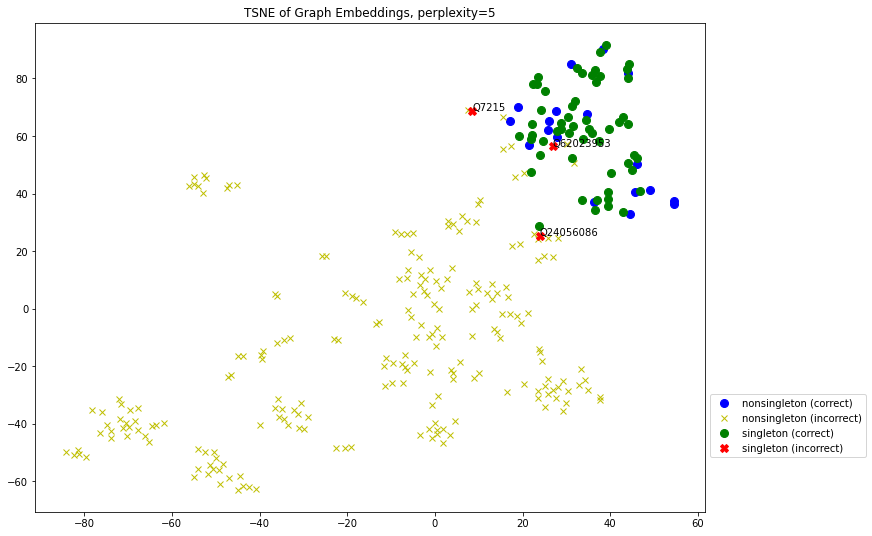

172 entities truncated


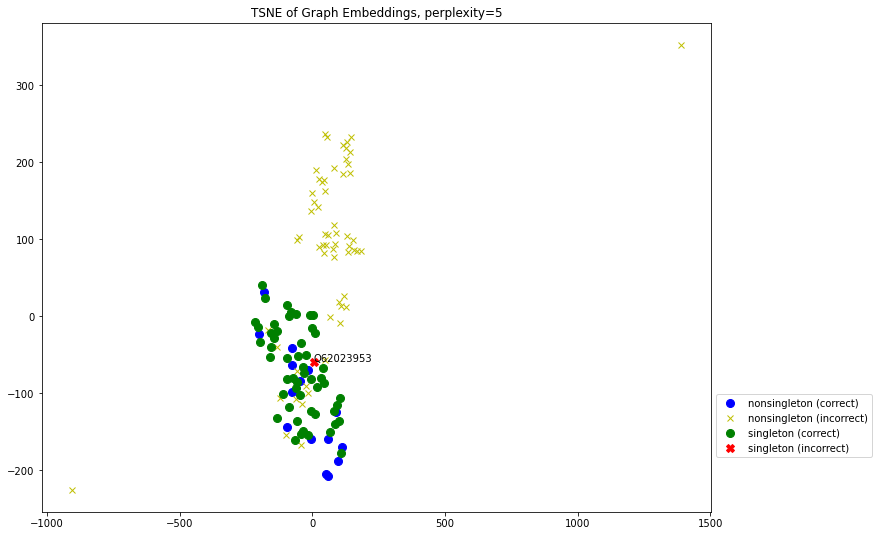

In [306]:
graph_entities_from_df(magazine, 'P123', truncate=None, perplexity=5)
graph_entities_from_df(magazine, 'P123', truncate=0.0005, perplexity=5, skip=True)
# graph_entities_from_df(magazine, 'P123', truncate=0.05, mode='fuzzy', perplexity=5)
# graph_entities_from_df(magazine, 'P123', truncate=0.05, mode='fuzzy', perplexity=5, skip=True)

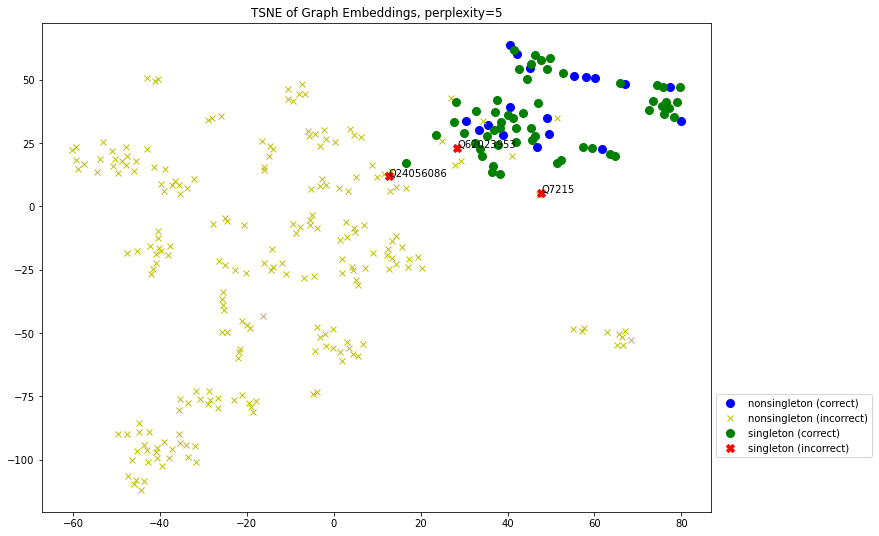

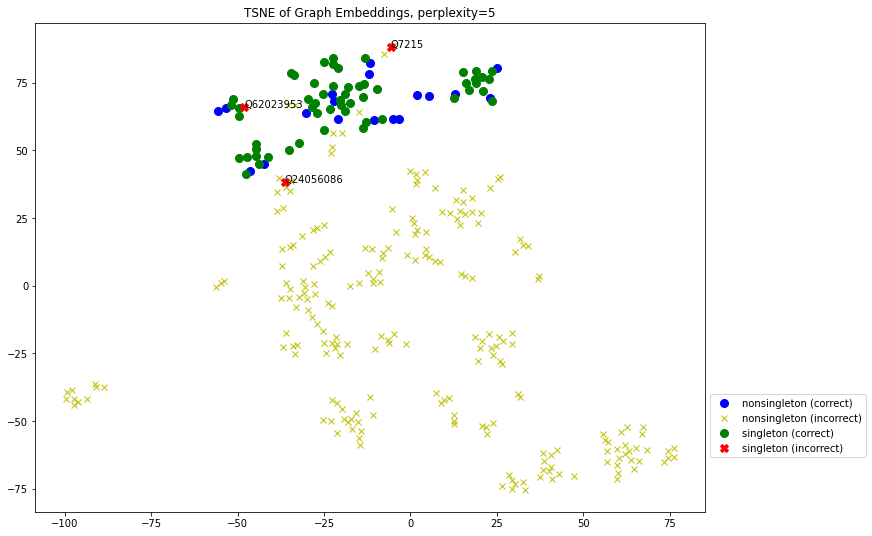

179 entities truncated


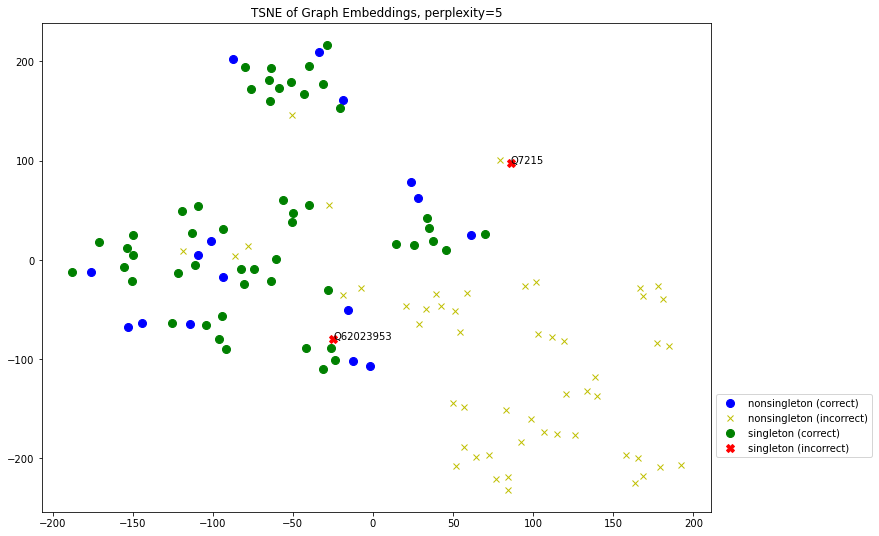

In [307]:
graph_entities_from_df(magazine, 'P31', truncate=None)
graph_entities_from_df(magazine, 'P31', truncate=0.0005, skip=True)
# graph_entities_from_df(magazine, 'P31', truncate=0.0005, mode='fuzzy')

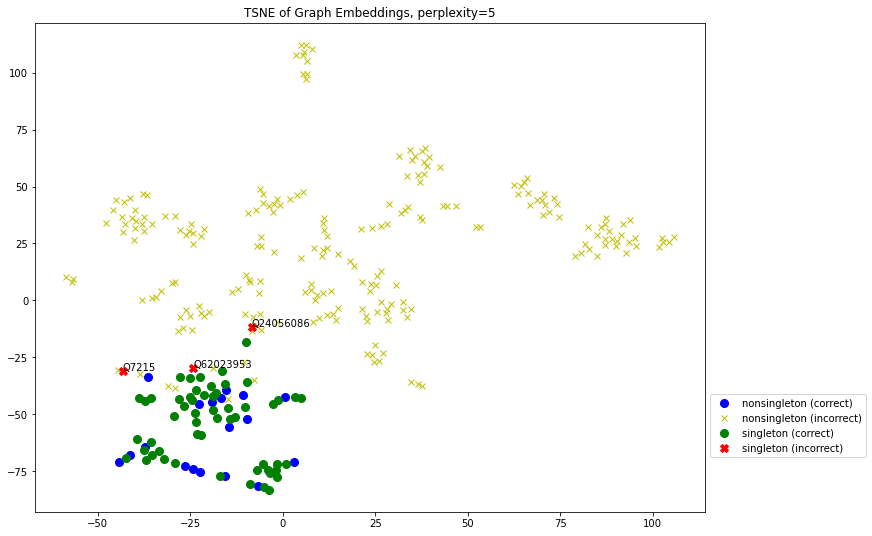

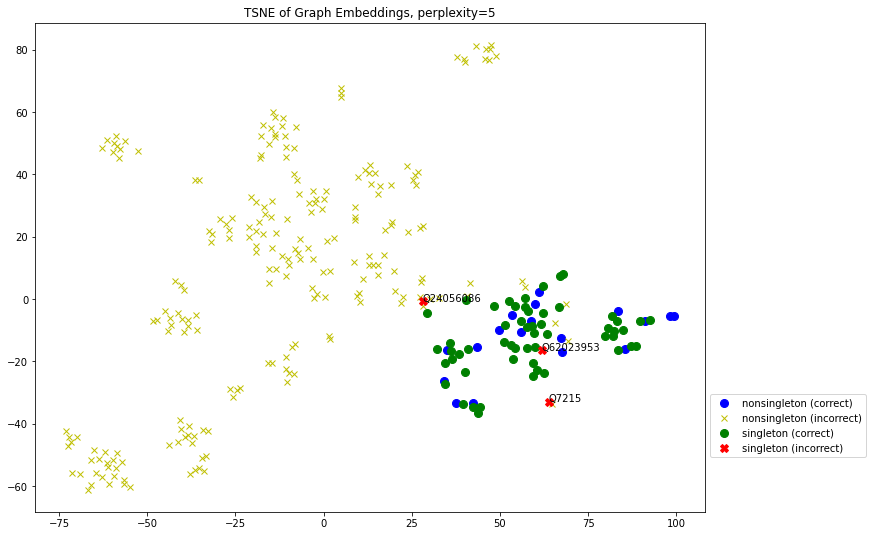

254 entities truncated


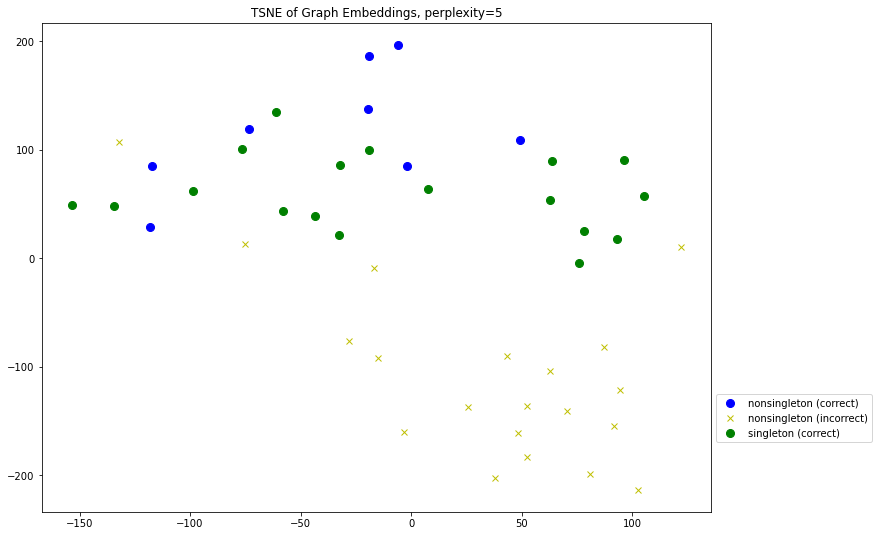

In [308]:
graph_entities_from_df(magazine, 'P101', truncate=None)
graph_entities_from_df(magazine, 'P101', truncate=0.0005, skip=True)
# graph_entities_from_df(magazine, 'P123', truncate=0.0005, mode='fuzzy')

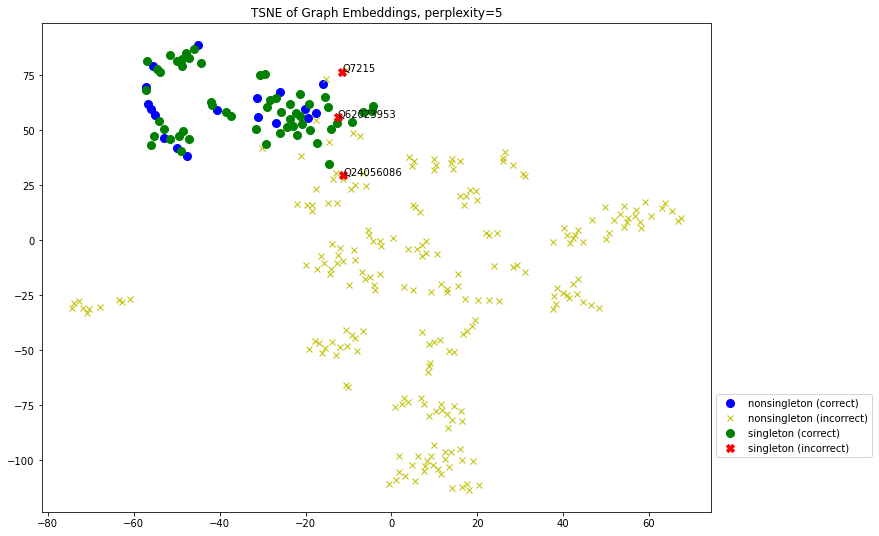

254 entities truncated


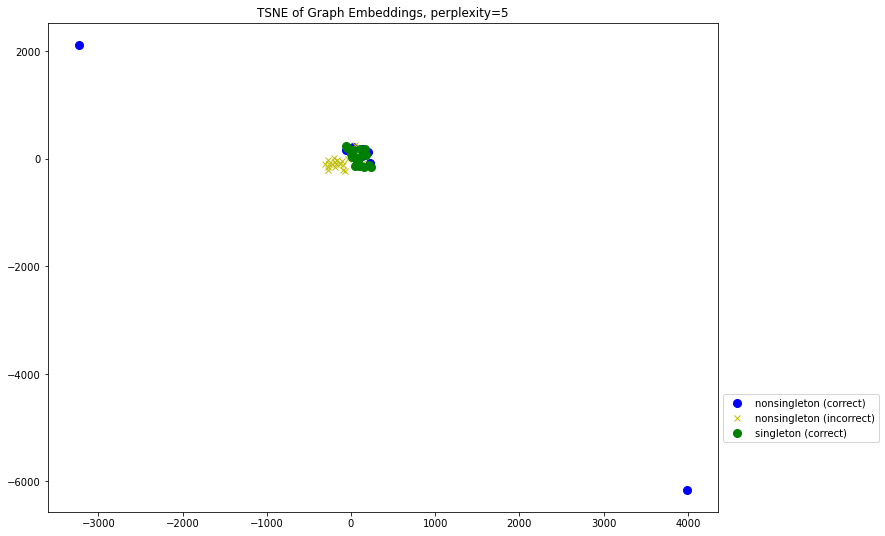

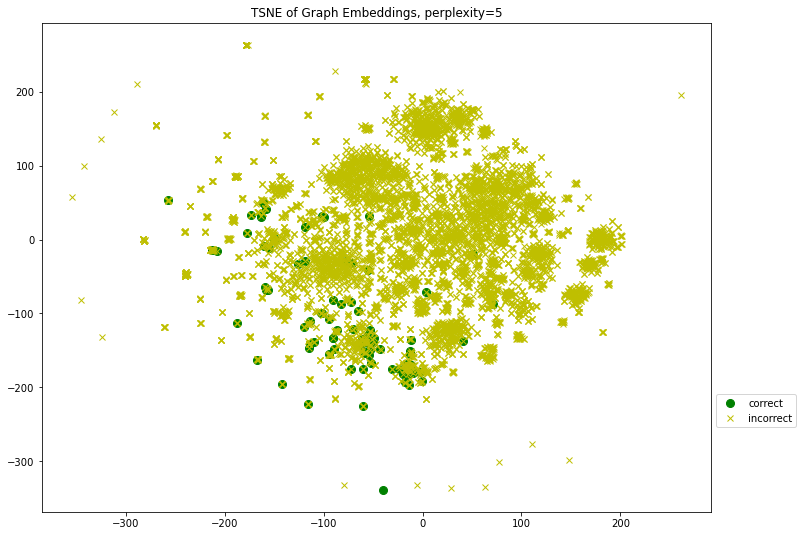

5697 entities truncated


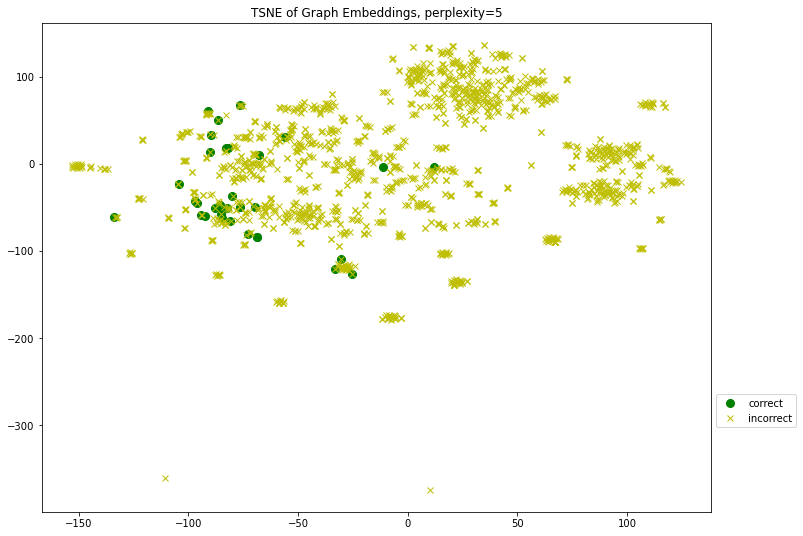

In [276]:
graph_entities_from_df(magazine, 'P101', truncate=0.0000005)
graph_entities_from_df(magazine, 'P101', truncate=0.0000005, mode='fuzzy')

In [269]:
calculate_truncate_percent(magazine, 'P101', 0.05, aggregate=False)

[0.6727272727272727, 1.0, 0.5555555555555556, 0.9107142857142857]